# Compute TKE dissipation rate from lidar quasi vertical stares

The stabilization table was rolling with the ship, so it sampled some component of the mean horizontal wind.

## The ship coordinate system
Define the ship coordinate to be "northward" toward the bow and "eastward" to starboard. The direction a wind is from is 0 from north, and increases to 90° easterly. The $x$ coordinate points forward (north) in this coordinate system, and the $y$ coordinate points to starboard (east). $z$ is upward for a right-handed coordinate system.

Pitch $\theta$ (y-axis) and roll $\phi$ (x axis) rotations are defined in this coordinate system. Positive roll angle is a rotation of the port upward; positive pitch angle is a rotation of the bow upward.

## Winds
The vertical wind is $w$. The ship-relative wind 
is $W$.

Ship-relative horizontal wind is
$ (U, V) = $ (-speed cos(dir), -speed sin(dir)).

Radial velocity away from the lidar is $\hat{w}$ with
$$
\hat{w}^2 = (-U sin\theta)^2 
+ (V cos\theta sin\phi)^2 
+ (W cos\theta cos\phi)^2 
$$.

## Relative velocity
We solve the measured Doppler radial velocity $\hat w$ for the air velocity,
$$
W^2 = \frac{ \hat{w}^2 
- (U sin\theta)^2 
- (V cos\theta sin\phi)^2 }
{(cos\theta cos\phi)^2}
$$.

## Vectors among the lidar, and two target volumes
The radial vector to the target volume is
$$
{\bf \hat{r}} =
\begin{pmatrix}
\hat x \\ \hat y \\ \hat z
\end{pmatrix}
=
({\rm range})
\begin{pmatrix}
-sin\theta \\
 cos\theta sin\phi \\
 cos\phi cos\theta
\end{pmatrix}
$$

The displacement between two *simultaneous* target
volumes is
$$
\bf{\hat r_1 - \hat r_2} = 
\begin{pmatrix}
\hat x \\
\hat y \\
\hat z
\end{pmatrix}
=
{\rm range}
\begin{pmatrix}
-sin \theta_1-(-sin \theta_2) \\
cos\theta_2 sin \phi_1 - cos\theta_2 sin \phi_2 \\
cos\theta_1 cos \phi_1 - cos\theta_2 cos\phi_2
\end{pmatrix}
$$

In the time $\tau$ the ship moves relative to the air a horizontal displacement of $(X, Y) = \tau(U,V)$. The total displacement of the sample volumes is 
$$
{\bf r_2 - r_1} = 
\begin{pmatrix}
\hat x + X\\
\hat y + Y\\
\hat z
\end{pmatrix}
$$
Expanding, the distance between the sample volumes is 
$$
R = |{\bf r_2 - r_1}| =
\begin{pmatrix}{|}
\tau U - &{\rm range}(sin\theta_1 + sin\theta_2) \\
\tau V + &{\rm range}(cos\theta_1 sin\phi_1 - cos\theta_2 sin\phi_2) \\
 & {\rm range}(cos\theta_1 cos\phi_1 - cos\theta_2 cos\phi_2)
\end{pmatrix}
$$
This is the displacement argument of the (second order) structure function 
$$
D(R) = \overline{(w_2-w_1)^2}
$$,
which behaves as $D = N + AR^{2/3}$.
The structure function is averaged as a function of $R$. We will retain sample pairs of $(D,R)$ and bin average in $R$, perhaps with bins equally populated by sample pairs.

## Ship motion fluctuations
The ship heave, pitch, and roll also induce fluctuating velocities in the transmitter that must be added. (The separation of scale between the mean ship-relative velocity and these fast fluctuations breaks down in maneuvers where the ship changes direction quickly.) Heave, pitch, and roll is either measured at the lidar on the stabilization table, where it can be added directly to the radial Doppler $\hat w$, measured in the ship orientation at the location of the lidar, or at a reference location on the ship (see survey).

Presently, I read a Notre Dame VectorNav file for measuring and correcting the motion of the table, but I don't know the quantities and units. The ship's POSMV IMU is also available from a reference location. If we use the POSMV, we need to calculate the velocities and moments from the heave and angular rates.

Assuming the ship is 
rigid, the heave is the same everywhere. Angular rates induce motion in proportion to the moment
${\bf L} = (L_x, L_y, L_z)$ 
be the displacement vector from the reference location 
(of the POSMV) to the lidar. At the lidar the ship
moves by 
$$
\dot{x} = -\dot\theta L_z\\
\dot{y} = \dot\phi L_z\\
\dot{z} = \dot\theta L_x - \dot\phi L_y
$$.
Varying yaw is ignored.


In [1]:
using Revise
using Pkg; Pkg.activate("/Users/deszoeks/Projects/ASTRAL/lidar")

using Dates
using DSP
using FFTW
using PyPlot
using Interpolations
using Statistics

# using CSV
# using NCDatasets
# using DataFrames
# using DelimitedFiles
# using Printf

  Activating project at `~/Projects/ASTRAL/lidar`


In [2]:
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x

anom(x; dims=1) = x.-mean(x; dims=dims)

anom (generic function with 1 method)

In [3]:
# functions for reading hpl files

"count the headlines before a line that starts with ****"
function numheaderlines(file)
    n = 0 
    open(file) do f
        while !startswith( readline(f), "****" )
            n += 1
        end
    end
    return n + 1
end

"""
header = read_streamlinexr_head(file_path)
Read the Halo Photonics StreamLineXR .hpl file header.
"""
function read_streamlinexr_head(file_path)
    # put the header in a Dict
    h = Dict(
        :nlines => countlines(file_path),
        :nheaderlines => 
        # variables defined outside the do block, defaults will be overwritten.
        :ngates => Int32(104),
        :gatelength => 30.0,
        :nrays => Int32(1), # or 40
        :start_time => DateTime(2024,5,2,10,0,0),
        :vel_resolution => 0.0380,
        :headr1 => split("time Azimuth Elevation Pitch Roll"),
        :units1 => split("hours degrees degrees degrees degrees"),
        :headr2 => ["Range Gate", "Doppler", "Intensity", "Beta"],
        :units2 => ["none", "(m/s)", "(SNR + 1)", "(m-1 sr-1)"]
    )

    # open and read the file header, updating the header dict a
    open(file_path) do file
        for _ in 1:2 # skip lines
            readline(file)
        end

        # read number of gates from line 3
        h[:ngates] = parse(Int32, last(split(readline(file)))) # 104
        # read gate length from line 4
        h[:gatelength] = parse(Float64, last(split(readline(file))))
        for _ in 5:6 # skip
            readline(file)
        end

        # read number of rays from line 7
        h[:nrays] = parse(Int32, last(split(readline(file)))) # 1 for Stare or 40 for User
        for _ in 8:9 # skip
            readline(file)
        end

        # read start time from line 10
        tl = split(readline(file))
        h[:start_time] = DateTime(tl[end-1]*tl[end], "yyyymmddHH:MM:SS.ss")
        # read velocity resolution (m/s) line 11
        h[:vel_resolution] = parse(Float64, last(split(readline(file))))
        readline(file) # skip line 12
        # read header 1 from line 13
        hdrln = split(readline(file))[5:end]
        h[:headr1] = hdrln[1:2:end]
        h[:units1] = hdrln[2:2:end]
        readline(file) # skip line 14
        # read header 2 from line 15
        hdrln = split(readline(file))[4:end] # but don't parse it
        h[:headr2] = ["Range Gate", "Doppler", "Intensity", "Beta"]
        h[:units2] = ["none", "(m/s)", "(SNR + 1)", "(m-1 sr-1)"]
        # for _ in 16:17 # skip
        #     readline(file)
        # end
    end

    return h
end

"""
modifying read_streamlinexr_data!(file_path, header, beams)
Read data and fill in the beams.
"""
function read_streamlinexr_stare!(file_path, h, beams, nheaderlines=17)
    # use header information in h
    nlines = h[:nlines]
    ngates = h[:ngates]

    # beams could be rays or times
    nbeams = round(Int, (nlines-nheaderlines) / (1+ngates)) # = nrays*ntimes
    beam_timeangles = zeros(nbeams, 5)
    beam_velrad = zeros(nbeams, ngates, 4)

    # for User wind profiles beam <--> VAD ray
    # for Stare beam <--> time

    # open and read the file
    open(file_path) do file
        for _ in 1:nheaderlines # skip header lines
            readline(file)
        end

        # now read data
        for ibeam = 1:nbeams
            # beam described by a batch of 1+ngates lines
            # Read the beam parameter line
            line = readline(file)
            beam_timeangles[ibeam,:] .= parse.(Float64, split(line))
            # Read each gate in the beam
            for igate = 1:ngates
                line = readline(file)
                beam_velrad[ibeam, igate,:] .= parse.(Float64, split(line))
            end
        end
    end # close the file

    # parse the variables into the dict beams
    # by beam
    beams[:time     ] .= beam_timeangles[:,1] # decimal hours
    beams[:azimuth  ] .= beam_timeangles[:,2] # degrees
    beams[:elevangle] .= beam_timeangles[:,3] # degrees
    beams[:pitch    ] .= beam_timeangles[:,4]
    beams[:roll     ] .= beam_timeangles[:,5]
    # by gate
    beams[:height   ] .= (beam_velrad[1,:,1].+0.5) .* h[:gatelength] # center of gate, assumes same for all beams

    # dependent variables (beam, gate)
    beams[:dopplervel] .= beam_velrad[:,:,2] # m/s
    beams[:intensity ] .= beam_velrad[:,:,3] # SNR + 1
    beams[:beta      ] .= beam_velrad[:,:,4] # m-1 sr-1  backscatter?
end

"""
beams, h = read_streamlinexr(file_path)
Read the Photonics StreamLineXR .hpl file data and header.
"""
function read_streamlinexr_stare(file_path, nheaderlines=17)
    # use header information in h
    h = read_streamlinexr_head(file_path)
    nlines = h[:nlines]
    ngates = h[:ngates]

    # beams could be rays or times
    nbeams = round(Int, (nlines-17) / (1+ngates)) # = nrays*ntimes
    # initialize a beams Dict
    beams = Dict(
        :time      => Vector{Union{Float32,Missing}}(missing, nbeams), # decimal hours
        :azimuth   => Vector{Union{Float32,Missing}}(missing, nbeams), # degrees
        :elevangle => Vector{Union{Float32,Missing}}(missing, nbeams),
        :pitch     => Vector{Union{Float32,Missing}}(missing, nbeams),
        :roll      => Vector{Union{Float32,Missing}}(missing, nbeams),

        :height    => Vector{Union{Float32,Missing}}(missing, ngates), # center of gate

        # dependent variables (beam, gate)
        :dopplervel => Matrix{Union{Float32,Missing}}(missing, nbeams,ngates), # m/s
        :intensity  => Matrix{Union{Float32,Missing}}(missing, nbeams,ngates), # SNR + 1
        :beta       => Matrix{Union{Float32,Missing}}(missing, nbeams,ngates) # m-1 sr-1  backscatter?
        )

    # read file and fill beams with data
    read_streamlinexr_stare!(file_path, h, beams, nheaderlines)
    return beams, h
end

read_streamlinexr_stare

In [4]:
# make a range function and check it
length( beams[:height] )
beams[:height][2]
range = 12.0 .+ 24.0.*((1:150).-1)
all(isapprox.(beams[:height], range; atol=1e-8))

LoadError: UndefVarError: `beams` not defined

In [11]:
# plotting functions

"plot_stare(beams) plots StreamlineXR lidar backscatter and Doppler velocity."
function plot_stare(beams::Dict)
    # data from dict
    time   = beams[:time]
    height = beams[:height]
    beta   = beams[:beta]
    dopplervel = beams[:dopplervel]
    intensity = beams[:intensity]

    plot_stare(time, height, beta, dopplervel, intensity) # returns the figure
end

function plot_stare(time::Vector, height::Vector, beta::Matrix, dopplervel::Matrix, intensity::Matrix)
    # plot_stare(time, height, beta, dopplervel, intensity)
    subplot(2,1,1)
    pcolormesh(time, height[4:end]/1e3, pd(beta[:,4:end]),
        cmap=ColorMap("RdYlBu_r"))
    ylim([0, 2])
    ylabel("height (km)")
    xlabel("time")
    colorbar()

    noisemask = intensity.>=noisethr # true for valid, false for noise
    subplot(2,1,2)
    pcolormesh(time, height[4:end]/1e3, pd(nannoise.(noisemask, dopplervel)[:,4:end]),
        cmap=ColorMap("RdYlBu_r"), vmin=-2, vmax=2)
    ylim([0, 2])
    ylabel("height (km)")
    xlabel("time")
    colorbar()
    
    tight_layout()
    return gcf()
end

plot_stare (generic function with 2 methods)

In [ ]:
# filters for Doppler velocity, not done yet...

"return x where f is true and NaN where f is false"
nannoise(f, x) = f ? x : NaN
"return x where f is true and missing where f is false"
missingnoise(f, x) = f ? x : missing

noisethr = 1.03
f(x) = x>noisethr # use intensity for x

# mean Doppler velocity
function get_mdv(f, dopplervel)
    X = missingnoise.(f, dopplervel)
    mapslices(x->mean(skipmissing(x)), X; dims=2)[:]
end

# Suggest only computing mdv for motion removal where
# there are nonnoise DVs for the whole chunk, so not to alias sampling differences.
# Then, only take the mean of the middle 5th quantile, to smoothly approximate the mode
#=
"""
Motion from Doppler velocity, by inferring displacement of the median velocity 
by the platform motion at each time.
"""
function get_mdv(f, dopplervel)
    # levels with Doppler data at all times in the chunk
    goodlevels = all(f, dopplervel; dims=1) # bool
    # median over whole chunk, continuously available levels
    chunkmedian = median(dopplervel[:,goodlevels]) # over both dims
    # median over vertical dim at each time
    timeslicemedian = median(dopplervel[:,goodlevels], dims=2)
    mdv = timeslicemedian - chunkmedian
end
# UNTESTED!!
# This modification circumvents issues with sampling and better separates the motion estimate
# from the air velocities, assuming the median of the overall velocity distribution is 
# unchanged, and the Doppler velocity is merely shifted at each time by the platform motion,
# but with zero average shift since mean(motion) = median(motion) = 0.
=#

remove_mdv(f, dopplervel) = dopplervel .- get_mdv(f, dopplervel)
remove_mdv!(f, dopplervel) = (dopplervel .-= get_mdv(f, dopplervel))

responsetype = Highpass(1/80; fs=1)
designmethod = Butterworth(4)
"highpass filter"
hp(x) = filtfilt(digitalfilter(responsetype, designmethod), x)



vel = X .- mdv # subtract mean heave vel
ii = isfinite.(mdv)
sum(ii)
plot(beams[:time])
bt = beams[:time]
sum(ismissing.(bt))  # yay no time is missing
sum(ismissing.(mdv)) # yay no mdv is missing!

# chunks
pkt = findall( diff(bt) .> 0.25/60 )
stt = pkt[1:end-1] .+ 1 # start
ent = pkt[2:end]       # end

xmdv = similar(mdv) # cross-quadrature transform of mdv, uninitialized
prof = zeros(size(X,2),length(stt))
i = 1
st = stt[i]
en = ent[i]
clf()
asx = hilbert(mdv[st:en]) # analytic signal
xmdv = imag(hilbert(mdv[st:en])) # mdv shifted by 90° phase
plot( mdv[st:en])
plot( xmdv )
sum(ismissing(xmdv))
pcolormesh( m2n.(pd(vel[st:en,:]) * xmdv ))
# vertical projection of mean-filtered velocity
# prof[:,i] = pd(vel[st:en,:]) * xmdv
# prof = pd(vel[st:en,:]) * xmdv


# for i in axes(stt)
#     st = stt[i]
#     en = ent[i]
#     xmdv[st:en] .= real.(ifft(im.*fft(mdv[st:en]))) # only do on continuous chunks
#     # prof[:,i] = pd(vel[st:en,:]) * xmdv[st:en]
# end

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/deszoeks/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('not enough values to unpack (expected 2, got 1)')
  File "/Users/deszoeks/.julia/conda/3/aarch64/lib/python3.10/site-packages/matplotlib/pyplot.py", line 3493, in pcolormesh
    __ret = gca().pcolormesh(
  File "/Users/deszoeks/.julia/conda/3/aarch64/lib/python3.10/site-packages/matplotlib/__init__.py", line 1465, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/Users/deszoeks/.julia/conda/3/aarch64/lib/python3.10/site-packages/matplotlib/axes/_axes.py", line 6292, in pcolormesh
    X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
  File "/Users/deszoeks/.julia/conda/3/aarch64/lib/python3.10/site-packages/matplotlib/axes/_axes.py", line 5792, in _pcolorargs
    nrows, ncols = C.shape[:2]


In [58]:
# continuous chunks functions

noisethr = 1.03

"chop a beam file and return a vector start and end time indices of continuous chunks"
function chunks(beams::Dict; timegap=0.25/60)
    bt = beams[:time] # hour
    # chunks
    pkt = findall( diff(bt) .> timegap )
    stt = [1; pkt .+ 1]         # start
    ent = [pkt; length(bt)]       # end
    return stt, ent
end

"convenience wrapper for broadcasting chunk subscripting" # not used
chk(x, st, en) = x[st:en,:]

"plot continuous chunks from one beams dict, makes one file per chunk"
function plot_chunks(beams, start_time)
    stt, ent = chunks(beams)
    lenchunk = ent .- stt .+ 1
    for ic in findall(lenchunk .> 100) # chunks long enough to be worth plotting
        st = stt[ic]
        en = ent[ic]
        dt = @. DateTime(Date(start_time)) + Second(round(Int64,3_600*beams[:time][st]))
        dstr = Dates.format(dt, dateformat"yyyymmdd_HHMM")
        
        # get data
        height = beams[:height]
        # subset the variables for the present chunk
        time = beams[:time][st:en]
        kys = Symbol.(split("beta dopplervel intensity"))
        (beta, dopplervel, intensity) = (beams[k][st:en,:] for k in kys)
        
        # remove the vertical-mean Doppler velocity
        # mdv = mapslices(x->mean(skipmissing(x)), dopplervel; dims=2)[:]
        # vel = dopplervel .- mdv # subtract mean heave vel
        noisemask = intensity.>=noisethr
        vel = remove_mdv(noisemask, dopplervel)
        
        # make the plot
        clf()
            # plot_stare(time, height, beta, dopplervel, intensity)
            subplot(2,1,1)
            pcolormesh((time.%1)*60, height[4:end]/1e3, pd(beta[:,4:end]),
                cmap=ColorMap("RdYlBu_r"), vmin=0, vmax=0.2*maximum(beta[:,4:end]))
            ylim([0, 2])
            ylabel("height (km)")
            xlabel("time (minute)")
            title("$(Dates.format(dt, dateformat"yyyy-mm-dd HH:MM"))\nbackscatter")
            colorbar()
        
             # true for valid, false for noise
            subplot(2,1,2)
            pcolormesh((time.%1)*60, height[4:end]/1e3, pd(nannoise.(noisemask, vel)[:,4:end]),
                cmap=ColorMap("RdYlBu_r"), vmin=-2, vmax=2)
            ylim([0, 2])
            ylabel("height (km)")
            xlabel("time (minute)")
            title("Doppler velocity (m/s)")
            colorbar()
            
            tight_layout()

        # save plot stamped with the chunk start time
        savefig(joinpath(lidardir,"plot","Chunk_$(dstr).png"))
        print(dstr*" ")
    end
end

plot_chunks

20240525_0600 20240525_0607 20240525_0617 20240525_0627 20240525_0637 20240525_0647 20240525_0657 

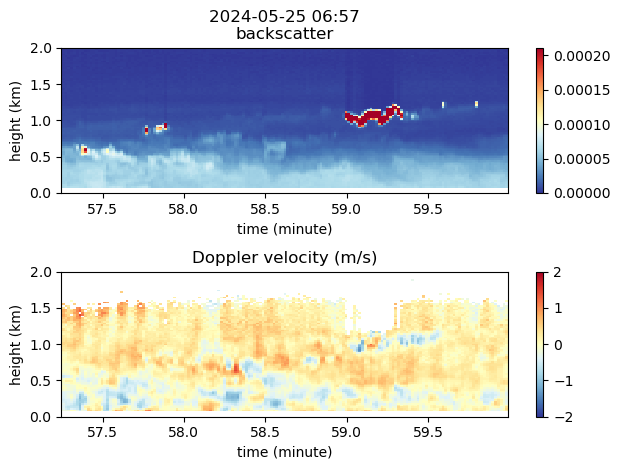

In [59]:
# test and precompile plot_chunks

lidardir = "./data/lidar"
datestamp = "20240525"
starefile = "Stare_116_$(datestamp)_06.hpl"
datafile = joinpath(lidardir, datestamp, starefile)
beams, head = read_streamlinexr_stare(datafile)
head[:start_time], (beams[:time][1:6].%1).*3600
@. DateTime(Date(head[:start_time])) + Millisecond(round(Int64,3_600_000*beams[:time][1:6]))

beams, head = read_streamlinexr_stare(joinpath(lidardir,datestamp,starefile))
plot_chunks(beams, head[:start_time])

20240428_0000 20240428_0005 20240428_0015 20240428_0025 20240428_0035 20240428_0045 20240428_0055 20240428_0100 20240428_0105 20240428_0115 20240428_0125 20240428_0135 20240428_0145 20240428_0155 20240428_0200 20240428_0205 20240428_0215 20240428_0225 20240428_0235 20240428_0245 20240428_0255 20240428_0300 20240428_0305 20240428_0315 20240428_0325 20240428_0335 20240428_0345 20240428_0355 20240428_0400 20240428_0405 20240428_0415 20240428_0425 20240428_0435 20240428_0445 20240428_0455 20240428_0500 20240428_0505 20240428_0515 20240428_0525 20240428_0535 20240428_0545 20240428_0555 20240428_0600 20240428_0605 20240428_0615 20240428_0625 20240428_0635 20240428_0645 20240428_0655 20240428_0700 20240428_0705 20240428_0715 20240428_0725 20240428_0735 20240428_0745 20240428_0755 20240428_0800 20240428_0805 20240428_0815 20240428_0825 20240428_0835 20240428_0845 20240428_0855 20240428_0900 20240428_0905 20240428_0915 20240428_0925 20240428_0935 20240428_0945 20240428_0955 20240428_1000 202404

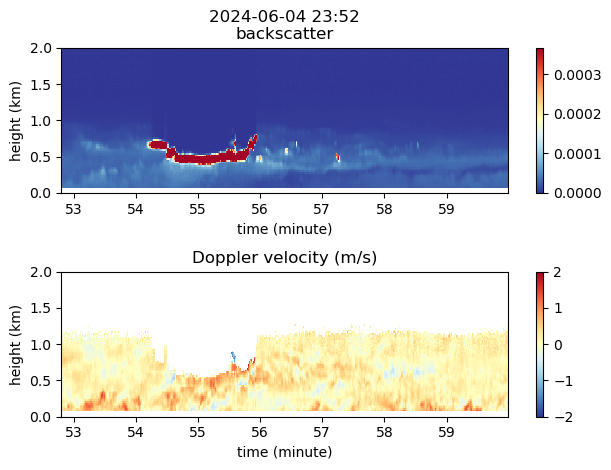

In [ ]:
# plot ~10 min chunks

for datestamp in filter(startswith("2024"), readdir(lidardir))
    for starefile in filter(startswith("Stare"), readdir(joinpath(lidardir,datestamp)))
        beams, head = read_streamlinexr_stare(joinpath(lidardir,datestamp,starefile))

        plot_chunks(beams, head[:start_time])
    end
    print("\n")
end

# Hourly Stare files have 1 start time in the header.
# Add decimal hours elapsed recorded for each beam.

In [178]:
# plot hourly
for datestamp in filter(startswith("2024"), readdir(lidardir))
    for starefile in filter(startswith("Stare"), readdir(joinpath(lidardir,datestamp)))
        beams, head = read_streamlinexr_stare(joinpath(lidardir,datestamp,starefile))
        clf()
        plot_stare(beams)
        fileout = starefile[1:end-4]*".png"
        savefig(joinpath(lidardir,"plot",fileout))
        print(fileout*", ")
    end
    print("\n")
end

Stare_116_20240428_00.png, Stare_116_20240428_01.png, Stare_116_20240428_02.png, Stare_116_20240428_03.png, Stare_116_20240428_04.png, Stare_116_20240428_05.png, Stare_116_20240428_06.png, Stare_116_20240428_07.png, Stare_116_20240428_08.png, Stare_116_20240428_09.png, Stare_116_20240428_10.png, 

LoadError: InterruptException:

In [119]:
lidardir = "./data/lidar"
datestamp = "20240525"
datafile = joinpath(lidardir, datestamp, "Stare_116_$(datestamp)_19.hpl")
beams, head = read_streamlinexr_stare(datafile)



LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/deszoeks/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('not enough values to unpack (expected 2, got 1)')
  File "/Users/deszoeks/.julia/conda/3/aarch64/lib/python3.10/site-packages/matplotlib/pyplot.py", line 3493, in pcolormesh
    __ret = gca().pcolormesh(
  File "/Users/deszoeks/.julia/conda/3/aarch64/lib/python3.10/site-packages/matplotlib/__init__.py", line 1465, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/Users/deszoeks/.julia/conda/3/aarch64/lib/python3.10/site-packages/matplotlib/axes/_axes.py", line 6292, in pcolormesh
    X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
  File "/Users/deszoeks/.julia/conda/3/aarch64/lib/python3.10/site-packages/matplotlib/axes/_axes.py", line 5792, in _pcolorargs
    nrows, ncols = C.shape[:2]


In [ ]:

subplot(4,1,2)
pcolormesh(beams[:time][:], beams[:height][4:end]/1e3, m2n.(pd(vel[:,4:end])),
    cmap=ColorMap("RdYlBu_r"), vmin=-2, vmax=2)
plot(beams[:time][:], 0.3*mdv.+1.0, linewidth=0.5, color="k")
plot(beams[:time][:], 0.3*xmdv.+1.0, linewidth=0.5, color="r")
# ylim([0, 2])
colorbar()
xlim([19.0, 19.10])
tight_layout()

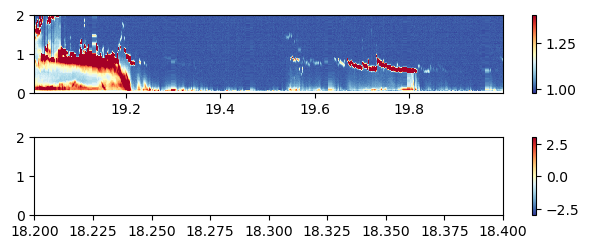

In [22]:
lidardir = "./data/lidar"
datestamp = "20240525"
datafile = joinpath(lidardir, datestamp, "Stare_116_$(datestamp)_19.hpl")
beams, head = read_streamlinexr_stare(datafile)

clf()
subplot(4,1,1)
pcolormesh(beams[:time][:], beams[:height][3:end]/1e3, pd(beams[:intensity][:,3:end]),
    cmap=ColorMap("RdYlBu_r"), vmin=0.98, vmax=1.4)
ylim([0, 2])
colorbar()

X = beams[:dopplervel]
vel = X .- mean(X, dims=1)
X[beams[:intensity] .<= 1.03] .= NaN
subplot(4,1,2)
pcolormesh(beams[:time][:], beams[:height][4:end]/1e3, pd(vel[:,4:end]),
    cmap=ColorMap("RdYlBu_r"), vmin=-3, vmax=3)
ylim([0, 2])
colorbar()

tight_layout()


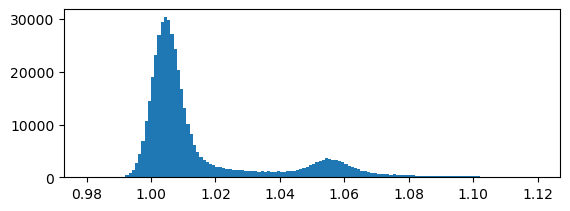

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 16.0, 27.0  …  117.0, 103.0, 101.0, 122.0, 122.0, 101.0, 117.0, 107.0, 88.0, 98.0], [0.98, 0.981, 0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988, 0.989  …  1.111, 1.112, 1.113, 1.114, 1.115, 1.116, 1.117, 1.118, 1.119, 1.12], (PyObject <matplotlib.patches.Rectangle object at 0x336320490>, PyObject <matplotlib.patches.Rectangle object at 0x336323d30>, PyObject <matplotlib.patches.Rectangle object at 0x336320100>, PyObject <matplotlib.patches.Rectangle object at 0x3362c8a60>, PyObject <matplotlib.patches.Rectangle object at 0x337812d10>, PyObject <matplotlib.patches.Rectangle object at 0x34e95da20>, PyObject <matplotlib.patches.Rectangle object at 0x34e95e320>, PyObject <matplotlib.patches.Rectangle object at 0x34e95e830>, PyObject <matplotlib.patches.Rectangle object at 0x34e95cb50>, PyObject <matplotlib.patches.Rectangle object at 0x34e95f8e0>, PyObject <matplotlib.patches.Rectangle object at 0x34e95fb20>, PyObject <matplotlib.patches.Rectangl

In [35]:
subplot(2,1,1)

hist(beams[:intensity][:,3:end][:], bins=0.98:0.001:1.12)

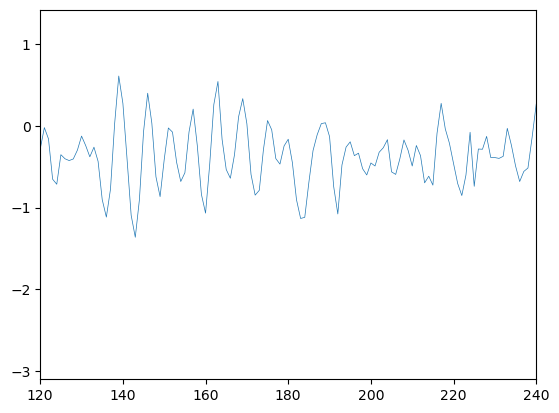

(120.0, 240.0)

In [44]:
masklowintensity(x, i, thr=1.03) = i<thr ? missing : x
"mean along dimension dims, skipping missing"
missmean(X; dims=1) = mapslices(x -> mean(skipmissing(x)), X, dims=dims)

vel = masklowintensity.(beams[:dopplervel], beams[:intensity])
mdv = missmean(vel, dims=2)
plot(mdv, linewidth=0.5)
xlim([120, 240])
    
    # Apply the mean_func along the specified dimensions



In [24]:
beams

Dict{Symbol, Array{Union{Missing, Float32}}} with 9 entries:
  :time       => [6.00528, 6.00556, 6.00585, 6.00613, 6.00641, 6.0067, 6.00698,…
  :dopplervel => [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; …
  :roll       => [-1.42, -3.15, -0.4, -1.21, -0.4, -2.54, -0.19, -1.83, 0.21, -…
  :beta       => [1.44775f-7 2.63448f-7 … 2.44864f-6 7.37624f-7; 4.07403f-7 5.5…
  :elevangle  => [90.02, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0  …
  :azimuth    => [359.99, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, …
  :height     => [12.0, 36.0, 60.0, 84.0, 108.0, 132.0, 156.0, 180.0, 204.0, 22…
  :intensity  => [1.00257 1.00467 … 1.00664 1.00198; 1.00724 1.00977 … 1.00989 …
  :pitch      => [0.11, 0.21, 0.62, -0.4, -0.51, 0.11, 0.41, -0.61, -0.2, 0.0  …

^ stop here ^

In [ ]:
# coherent filtering

using FFTW
using Plots

function remove_coherent_component(signal1::Vector{Float64}, signal2::Vector{Float64})
    # Fourier Transform of the signals
    S1 = fft(signal1)
    S2 = fft(signal2)
    
    # Compute cross-spectral density
    P12 = S1 .* conj(S2)
    # P21 = conj(P12)
    
    # Compute auto-spectral density
    P11 = S1 .* conj(S1)
    P22 = S2 .* conj(S2)
    
    # Compute coherence
    coherence = abs.(P12).^2 ./ (P11 .* P22)
    
    # Compute the coherent part
    coherent_part_S1 = coherence .* S2
    coherent_part_S2 = coherence .* S1
    
    # Remove the coherent part
    clean_S1 = S1 .- coherent_part_S1
    clean_S2 = S2 .- coherent_part_S2
    
    # Inverse Fourier Transform to get the time-domain signals
    clean_signal1 = real(ifft(clean_S1))
    clean_signal2 = real(ifft(clean_S2))
    
    return clean_signal1, clean_signal2
end

# Example usage
fs = 1000  # Sampling frequency
t = 0:1/fs:1-1/fs  # Time array
signal1 = sin.(2 * π * 50 * t) .+ 0.5 .* randn(length(t))  # Signal 1 with noise
signal2 = sin.(2 * π * 50 * t) .+ 0.5 .* randn(length(t))  # Signal 2 with noise

clean_signal1, clean_signal2 = remove_coherent_component(signal1, signal2)

# Plot the results
plot(t, signal1, label="Original Signal 1")
plot!(t, clean_signal1, label="Cleaned Signal 1", linestyle=:dash)

plot(t, signal2, label="Original Signal 2")
plot!(t, clean_signal2, label="Cleaned Signal 2", linestyle=:dash)


LoadError: ArgumentError: Package FFTW not found in current path.
- Run `import Pkg; Pkg.add("FFTW")` to install the FFTW package.